# Homework 3 - Logistic Regression, SVM, Neural Network

---

## Context

This file is the homework practice from my university course "Fundamentals of
data analytics".
Below are the cover of my  prediction.

---

## Homework requirement

Please implement 3 classifiers to predict the stock movement
* Logistic Regression
* SVM
* Neural Network

---

## Source

[Dataset](https://www.sharecast.com/index/SP_500/prices/download) - Sp500 -
ShareCast

* Training set: 02/Jan/2009 ~ 29/Dec/2017
* Testing set: 02/Jan/2018 ~ 31/Dec/2018

---

## Import Dataset

Import dataset

In [1]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('input/database.csv')
dataset.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952


---

## Preparation

### Define variables

Add independent variables to the dataset to help the prediction

* 10-days Average: the moving average of close price in 10 days
* 10-days Correlation: the correlation of the close price in 10 days
* Difference of Open & Close: the difference of the open price in today and
  the close price in previous day
* Difference of Open & Open: the difference of the open price in today and the
  open price in previous day

In [2]:
dataset['10-days Average'] = dataset['Close Price'].rolling(window=10).mean()
dataset['10-days Correlation'] = \
    dataset['Close Price'].rolling(window=10). corr(dataset['10-days Average'])
dataset['Difference of Open & Close'] = \
    dataset['Open Price'] - dataset['Close Price'].shift(1)
dataset['Difference of Open & Open'] = \
    dataset['Open Price'] - dataset['Open Price'].shift(1)

### Define the result

If the close price is higher than the previous day, marked as 1. Otherwise, 0.

In [3]:
dataset['Gain or Loss'] = \
    np.where(dataset['Close Price'] - dataset['Close Price'].shift(1) > 0, 1, 0)

### Fill the NaN value

Below we check whether the NaN value exists in the dataset. If it exists, we
fill it with 0.

In [4]:
dataset.isnull().sum()

Date                           0
Open Price                     0
Close Price                    0
High Price                     0
Low Price                      0
Volume                         0
10-days Average                9
10-days Correlation           18
Difference of Open & Close     1
Difference of Open & Open      1
Gain or Loss                   0
dtype: int64

In [5]:
dataset.fillna(0, inplace=True)
dataset.isnull().sum()

Date                          0
Open Price                    0
Close Price                   0
High Price                    0
Low Price                     0
Volume                        0
10-days Average               0
10-days Correlation           0
Difference of Open & Close    0
Difference of Open & Open     0
Gain or Loss                  0
dtype: int64

### Split the training set and testing set by date

By the requirement of the homework, we split up the data by date

In [6]:
def date_str(x):
    import datetime
    dd, mm, yy = x
    date = datetime.datetime(yy, mm, dd)
    return date.strftime('%d-%b-%Y')

date = \
    [(dataset.at[0, 'Date'], date_str([29, 12, 2017])),
     (date_str([2, 1, 2018]), dataset.at[dataset.last_valid_index(), 'Date'])]
print('Training dataset: {}'.format(date[0]))
print('Testing dataset: {}'.format(date[1]))

Training dataset: ('02-Jan-2009', '29-Dec-2017')
Testing dataset: ('02-Jan-2018', '31-Dec-2018')


In [7]:
training_set = dataset.iloc[
    dataset[dataset['Date'] == date[0][0]].index[0]:
    dataset[dataset['Date'] == date[0][1]].index[0] + 1, :]
testing_set = dataset.iloc[
    dataset[dataset['Date'] == date[1][0]].index[0]:
    dataset[dataset['Date'] == date[1][1]].index[0] + 1, :]

### Set Index

Let us set the index by Date

In [8]:
training_set.set_index('Date', inplace=True)
testing_set.set_index('Date', inplace=True)

### Split the attribute and answer

We predict the stock result by tracking the "Gain or Loss" attribute. Split up
the dataset into 4 subsets.

In [9]:
training_attribute = training_set.drop(columns=['Gain or Loss', 'Volume'])
training_answer = training_set['Gain or Loss']

testing_attribute = testing_set.drop(columns=['Gain or Loss', 'Volume'])
testing_answer = testing_set['Gain or Loss']

### Encode the dataset

Cover the dataset by using the LabelEncoder

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
training_answer = label_encoder.fit_transform(training_answer)
testing_answer = label_encoder.fit_transform(testing_answer)

### Training result data store

We need a place to store the result. Make a new dataframe to achieve it.

In [11]:
training_result = \
    pd.DataFrame(training_attribute.reset_index().loc[:, ['Date']])
training_result['Answer'] = training_answer

testing_result = \
    pd.DataFrame(testing_attribute.reset_index().loc[:, ['Date']])
testing_result['Answer'] = testing_answer


---

## Basic dataset info

Below shows the size of the set

In [12]:
print('How many file is in the training set: {}'.format(
    training_set.shape[0]))
print('How many file is in the test set: {}'.format(
    testing_set.shape[0]))

How many file is in the training set: 2264
How many file is in the test set: 252


Below shows the basic info of the data.

In [13]:
training_set.describe()

,Open Price,Close Price,High Price,Low Price,Volume,10-days Average,10-days Correlation,Difference of Open & Close,Difference of Open & Open,Gain or Loss
count,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000
mean,1656.142686,1656.767562,1664.427054,1647.425128,2.948755e+09,1649.622438,0.399444,0.157200,0.788940,0.545936
std,485.292193,485.226120,484.808706,485.576116,1.351675e+09,492.752082,0.468154,2.767832,13.645306,0.497995
min,679.280000,676.530000,695.270000,666.790000,5.181584e+08,0.000000,-0.904145,-19.180000,-78.250000,0.000000
25%,1238.602500,1239.337500,1246.695000,1227.587500,2.048980e+09,1233.110000,0.065722,-0.820000,-5.672500,0.000000
50%,1649.135000,1650.405000,1656.145000,1639.600000,2.506637e+09,1645.724000,0.533908,0.010000,1.395000,1.000000
75%,2070.300000,2071.190000,2079.507500,2058.757500,3.373334e+09,2069.041750,0.796472,1.260000,8.190000,1.000000
max,2692.710000,2690.160000,2694.970000,2685.920000,9.120100e+09,2681.887000,0.988563,21.640000,70.020000,1.000000


In [14]:
testing_set.describe()

,Open Price,Close Price,High Price,Low Price,Volume,10-days Average,10-days Correlation,Difference of Open & Close,Difference of Open & Open,Gain or Loss
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000,252.000000,252.000000,252.000000,252.000000
mean,2747.910397,2746.030873,2762.747778,2730.143929,2.154050e+09,2749.844397,0.323734,1.217778,-0.754802,0.523810
std,99.017479,100.251272,92.991345,106.490954,4.538626e+08,85.982293,0.527821,12.558050,27.902305,0.500427
min,2363.120000,2351.100000,2410.340000,2346.580000,9.516523e+08,2478.332000,-0.983363,-37.710000,-126.280000,0.000000
25%,2689.465000,2690.512500,2705.847500,2663.677500,1.879841e+09,2695.244250,-0.083015,-5.230000,-12.015000,0.000000
50%,2742.170000,2741.920000,2755.575000,2725.290000,2.063820e+09,2735.946500,0.436377,1.870000,0.185000,1.000000
75%,2811.430000,2814.322500,2824.802500,2800.630000,2.341078e+09,2816.067250,0.776135,8.237500,15.615000,1.000000
max,2936.760000,2930.750000,2940.910000,2927.110000,4.560164e+09,2920.283000,0.989670,82.370000,79.380000,1.000000


Below shows the stack plot

In [15]:
column_show = ['Open Price', 'Close Price', 'High Price', 'Low Price',
               '10-days Average']
_ = dataset.plot(kind='line', x='Date', y=column_show,
                 figsize=(12,10), subplots=False, grid=True,
                 title='Stock Roadmap from {} to {}'.format(date[0][0],
                                                            date[1][1]))

As shown in the figure, the overall stock rate is improving.
But more importantly, the Close Price is close to the rest attribute. This is
important info since it can predict the stock movement from testing set.

---

## Logistic Regression

First, let us use the Logistic Regression model to predict the result.

### Import LogisticRegression model

### Import LogisticRegression model

In [16]:
from sklearn.linear_model import LogisticRegression

logrec_model = LogisticRegression(random_state=0, solver='lbfgs',
                                  multi_class='multinomial', max_iter=1000)
logrec_model.fit(training_attribute, training_answer)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### Predict the Gain or loss

In [17]:
logrec_training_predict = logrec_model.predict(training_attribute)
logrec_testing_predict = logrec_model.predict(testing_attribute)


### Record the result

In [18]:
training_result['Logistic Regression Predict'] = logrec_training_predict
testing_result['Logistic Regression Predict'] = logrec_testing_predict

### Accuracy

In [19]:
print('Accuracy of training predict: {}'.format(
    logrec_model.score(training_attribute, training_answer)))

Accuracy of training predict: 0.9960247349823321


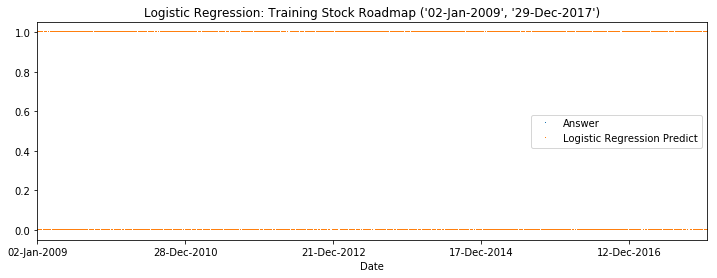

In [20]:
column_show = ['Answer', 'Logistic Regression Predict']
_ = training_result.plot(
    kind='line', x='Date', y=column_show,
    figsize=(12, 4), subplots=False, style=',',
    title='Logistic Regression: Training Stock Roadmap {}'.format(date[0]))

In [21]:
print('Accuracy of testing predict: {}'.format(
    logrec_model.score(testing_attribute, testing_answer)))

Accuracy of testing predict: 1.0


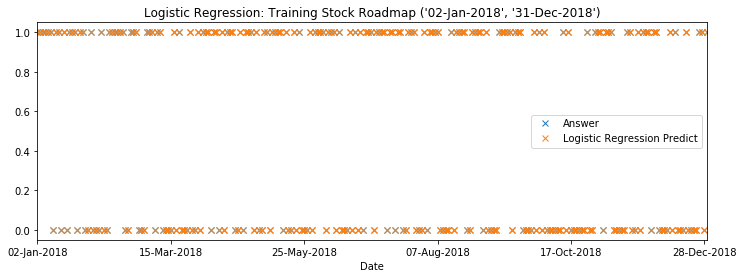

In [22]:
column_show = ['Answer', 'Logistic Regression Predict']
_ = testing_result.plot(
    kind='line', x='Date', y=column_show,
    figsize=(12, 4), subplots=False, style='x',
    title='Logistic Regression: Training Stock Roadmap {}'.format(date[1]))

### Coefficient

In [23]:
pd.DataFrame(zip(training_attribute.columns, np.transpose(logrec_model.coef_)))

,0,1
0,Open Price,[-1.1234309557917452]
1,Close Price,[1.1476007737116245]
2,High Price,[-0.020502040313513832]
3,Low Price,[-0.006998042603225656]
4,10-days Average,[0.0032728714906275105]
5,10-days Correlation,[0.20934444906248428]
6,Difference of Open & Close,[1.1408733884873905]
7,Difference of Open & Open,[-0.004095381219420196]


This model recognized the "Close Price" and "Difference of Open & Close"
as the influential variables. Since the result is based on Close Price,
it is reasonable.

### Class Probabilities

In [24]:
print(logrec_model.predict_proba(testing_attribute))

[[1.43347953e-022 1.00000000e+000]
 [1.36356409e-017 1.00000000e+000]
 [2.40813477e-011 1.00000000e+000]
 [1.45168688e-019 1.00000000e+000]
 [3.53129730e-005 9.99964687e-001]
 [3.89787351e-004 9.99610213e-001]
 [9.98978642e-001 1.02135784e-003]
 [9.99378989e-020 1.00000000e+000]
 [5.52211604e-019 1.00000000e+000]
 [1.00000000e+000 1.09459253e-010]
 [1.76817658e-026 1.00000000e+000]
 [9.99972128e-001 2.78721243e-005]
 [7.23027759e-013 1.00000000e+000]
 [6.07541437e-023 1.00000000e+000]
 [1.14361092e-006 9.99998856e-001]
 [9.78927789e-001 2.10722110e-002]
 [1.85023782e-002 9.81497622e-001]
 [8.64613762e-034 1.00000000e+000]
 [1.00000000e+000 5.35046030e-020]
 [1.00000000e+000 2.12520975e-031]
 [4.10462721e-002 9.58953728e-001]
 [9.90237336e-001 9.76266442e-003]
 [1.00000000e+000 5.07103254e-060]
 [1.00000000e+000 8.36580023e-113]
 [1.43295310e-046 1.00000000e+000]
 [1.00000000e+000 1.14182221e-014]
 [1.00000000e+000 4.08519774e-100]
 [1.40327328e-039 1.00000000e+000]
 [1.32719721e-036 1.

### Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix

print(pd.DataFrame(confusion_matrix(testing_answer, logrec_testing_predict),
                   index=[-1, 1], columns=[-1, 1]))

     -1    1
-1  120    0
 1    0  132


---

## SVM

Now, we will try the SVM model to predict the result

### Standardization

Before we operate the model, we need to standardize the dataset.

In [26]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
standard_scaler.fit(training_attribute)
svm_training_attribute = standard_scaler.transform(training_attribute)
svm_testing_attribute = standard_scaler.transform(testing_attribute)
#### Import SVM model

In [27]:
from sklearn.svm import SVC

svm_model = SVC(C=0.5, kernel='linear', probability=True)
svm_model.fit(svm_training_attribute, training_answer)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Predict the Gain or loss

In [28]:
svm_training_predict = svm_model.predict(training_attribute)
svm_testing_predict = svm_model.predict(testing_attribute)

### Record the result

In [29]:
training_result['SVM Predict'] = logrec_training_predict
testing_result['SVM Predict'] = logrec_testing_predict

### Accuracy

In [30]:
print('Accuracy of training predict: {}'.format(
    svm_model.score(training_attribute, training_answer)))

Accuracy of training predict: 0.463339222614841


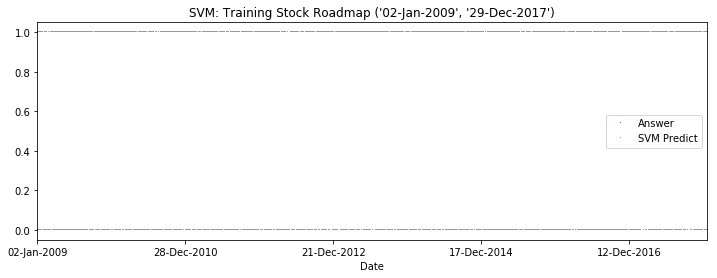

In [31]:
column_show = ['Answer', 'SVM Predict']
_ = training_result.plot(
    kind='line', x='Date', y=column_show,
    figsize=(12, 4), subplots=False, style=',',
    title='SVM: Training Stock Roadmap {}'.format(date[0]))

In [32]:
print('Accuracy of testing predict: {}'.format(
    svm_model.score(testing_attribute, testing_answer)))

Accuracy of testing predict: 0.4801587301587302


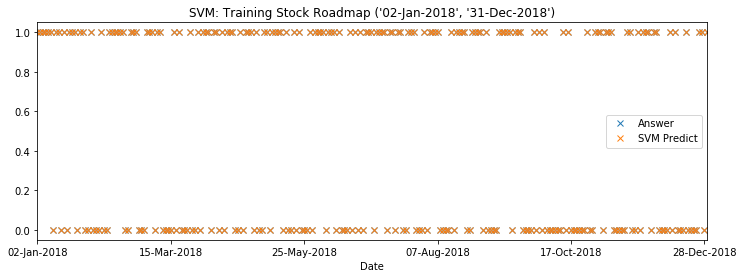

In [33]:
column_show = ['Answer', 'SVM Predict']
_ = testing_result.plot(
    kind='line', x='Date', y=column_show,
    figsize=(12, 4), subplots=False, style='x',
    title='SVM: Training Stock Roadmap {}'.format(date[1]))

### Support Vectors

In [34]:
svm_model.n_support_

array([854, 856])

In [35]:
print("Prediction: {}".format(svm_testing_predict))
print("Real label: {}".format(testing_answer))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Real label: [1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1
 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1
 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1
 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1
 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0
 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 0 0 1
 1 0 0 1 0 1 1

### Class Probabilities

In [36]:
print(svm_model.predict_proba(testing_attribute))

[[9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999

### Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix

print(pd.DataFrame(confusion_matrix(testing_answer, svm_testing_predict),
                   index=[-1, 1], columns=[-1, 1]))

     -1   1
-1  120   0
 1  131   1


---

## Neural Network

The third model we will use is neural network.

### Preprocessing

To ensure the model fit perfectly, let's preprocess the data first.

In [38]:
from sklearn import preprocessing

nn_training_attribute = preprocessing.normalize(training_attribute)
nn_testing_attribute = preprocessing.normalize(testing_attribute)

### Activation Function

Create the activation function to the network

In [39]:
from keras import models, layers, optimizers, regularizers
import tensorflow as tf

neural_network_model = models.Sequential()
neural_network_model.add(layers.Dense(input_dim=8,
                                      units=8,
                                      activation='relu'))
neural_network_model.add(layers.Dense(input_dim=8,
                                      units=1,
                                      activation='sigmoid'))
neural_network_model.compile(loss='binary_crossentropy',
                             optimizer=optimizers.Adam(lr=0.1),
                             metrics=['accuracy'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


### Model Train

The model is set. It's time to train the model. We will train this model once
and see how thing go.

In [40]:
history = neural_network_model.fit(nn_training_attribute,
                                   training_answer,
                                   epochs=8,
                                   batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/8
2264/2264 [==============================] - 0s 155us/step - loss: 0.6929 - acc: 0.5230
Epoch 2/8
2264/2264 [==============================] - 0s 38us/step - loss: 0.6900 - acc: 0.5389
Epoch 3/8
2264/2264 [==============================] - 0s 31us/step - loss: 0.6902 - acc: 0.5336
Epoch 4/8
2264/2264 [==============================] - 0s 34us/step - loss: 0.6918 - acc: 0.5468
Epoch 5/8
2264/2264 [==============================] - 0s 40us/step - loss: 0.6905 - acc: 0.5504
Epoch 6/8
2264/2264 [==============================] - 0s 46us/step - loss: 0.6907 - acc: 0.5459
Epoch 7/8
2264/2264 [==============================] - 0s 42us/step - loss: 0.6897 - acc: 0.5433
Epoch 8/8
2264/2264 [==============================] - 0s 42us/step - loss: 0.6906 - acc: 0.5371


### Loss function

Below shows the loss function of this model

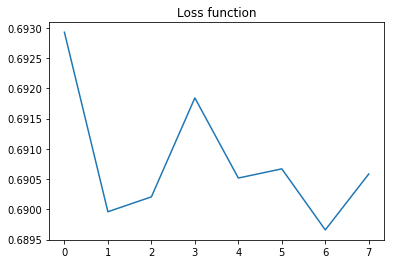

In [41]:
from matplotlib import pyplot as plt

losses = history.history['loss']
plt.clf()
plt.plot(range(len(losses)), losses)
plt.title('Loss function')
plt.show()

### Accuracy

In [42]:
print('Accuracy of training predict: {}'.format(
    neural_network_model.evaluate(nn_training_attribute, training_answer)[1]))

2264/2264 [==============================] - 0s 37us/step
Accuracy of training predict: 0.5459363958650258


In [43]:
print('Accuracy of testing predict: {}'.format(
    neural_network_model.evaluate(testing_attribute, testing_answer)[1]))

252/252 [==============================] - 0s 26us/step
Accuracy of testing predict: 0.5238095242825765


### Non-Determinacy

We only train this model for once. The parameters in the network is randomly
set.
Now we will train this model for 30 times and see if we can find something
useful.

In [44]:
def model_train_and_evaluate(model, x_train, y_train, x_test, y_test, times=30):
    from tqdm import tqdm

    training_accuracies = []
    testing_accuracies = []

    with tqdm(total=times) as progress_bar:
        for _ in range(times):
            model.fit(x_train,
                                y_train,
                                epochs=8,
                                batch_size=32,
                                verbose=0)
            training_accuracies.append(model.evaluate(x_train,
                                                      y_train,
                                                      verbose=0)[1])
            testing_accuracies.append(model.evaluate(x_test,
                                                     y_test,
                                                     verbose=0)[1])
            progress_bar.update()

    print('Accuracy of training predict: {}'.format(
        np.average(training_accuracies)))
    print('Accuracy of testing predict: {}'.format(
        np.average(testing_accuracies)))

    return training_accuracies, testing_accuracies

In [45]:
training_accuracies, testing_accuracies = \
    model_train_and_evaluate(neural_network_model,
                             nn_training_attribute,
                             training_answer,
                             testing_attribute,
                             testing_answer)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.45it/s]


Accuracy of training predict: 0.5367491167236131
Accuracy of testing predict: 0.5190476197571982


### Accuracies plot

After the training process, we can check the accuracies now.

In [46]:
def violinplot(x_list, title_list):
    plt.clf()
    _, axes = plt.subplots(nrows=1, ncols=len(x_list), figsize=(12, 10))

    for index, axis in enumerate(axes):
        axis.violinplot(x_list[index])
        axis.set_title(title_list[index])
        axis.text(0.005, 0.005, 'Min: {:.4}'.format(np.min(x_list[index])),
                  fontsize=12,
                  transform=axis.transAxes)
        axis.text(0.005, 0.025, 'Max: {:.4}'.format(np.max(x_list[index])),
                  fontsize=12,
                  transform=axis.transAxes)

    plt.show()

<Figure size 432x288 with 0 Axes>

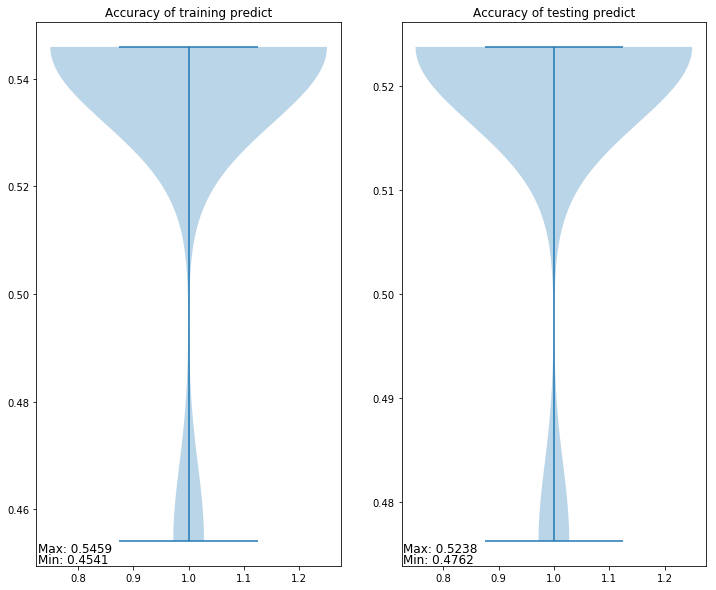

In [47]:
violinplot([training_accuracies, testing_accuracies],
           ['Accuracy of training predict', 'Accuracy of testing predict'])

The accuracy is around 54%. We will try to beat this record.

### Beat the Baseline

Now with the prediction recorded, it time to beat the base line.

Remodel the model

* Add a new layer
* Wider the existed layer
* More epoches

In [48]:
neural_network_model = models.Sequential()
neural_network_model.add(layers.Dense(input_dim=8,
                                      units=12,
                                      activation='relu',
                                      kernel_regularizer=regularizers.l2(0)))
neural_network_model.add(layers.Dense(input_dim=16,
                                      units=16,
                                      activation='tanh',
                                      kernel_regularizer=regularizers.l2(0)))
neural_network_model.add(layers.Dense(input_dim=16,
                                      units=1,
                                      activation='sigmoid',
                                      kernel_regularizer=regularizers.l2(0)))
neural_network_model.compile(loss='binary_crossentropy',
                             optimizer=optimizers.Adam(lr=0.1),
                             metrics=['accuracy'])

In [49]:
history = neural_network_model.fit(
    nn_training_attribute,
    training_answer,
    epochs=50,
    batch_size=32,
    verbose=False)

### Show the loss function

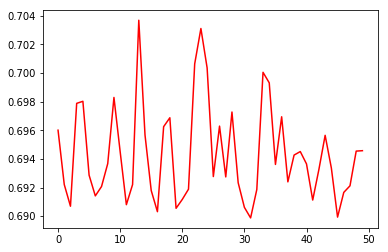

In [50]:
losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

### Accuracy

In [51]:
nn_training_accuracy = \
    neural_network_model.evaluate(nn_training_attribute, training_answer)[1]

2264/2264 [==============================] - ETA:  - 0s 40us/step


In [52]:
print('Accuracy of training predict: {}'.format(nn_training_accuracy))

Accuracy of training predict: 0.5459363958650258


In [53]:
nn_testing_accuracy = \
    neural_network_model.evaluate(nn_testing_attribute, testing_answer)[1]

252/252 [==============================] - ETA:  - 0s 46us/step


In [54]:
print('Accuracy of testing predict: {}'.format(nn_testing_accuracy))

Accuracy of testing predict: 0.5238095242825765


---

## Prediction Analysis

In [55]:
accuracy = [logrec_model.score(testing_attribute, testing_answer),
    svm_model.score(testing_attribute, testing_answer),
    neural_network_model.evaluate(nn_testing_attribute, testing_answer)[1]]
accuracy = pd.DataFrame(accuracy,
    index=['Logistic Regression Model', 'SVM Model', 'Neural Network Model'],
    columns=['Accuracy'])

accuracy.head()

252/252 [==============================] - ETA:  - 0s 28us/step


,Accuracy
Logistic Regression Model,1.000000
SVM Model,0.480159
Neural Network Model,0.523810


Logistic Regression has the perfect accuracy among the rest models. Since
logistic regression predict the sign of the gain and loss, it is suited for
stock prediction.

In this homework. We show 3 models, their basic and prediction. It's best to
know the dataset first, then choose the training model.